In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as mg
from PIL import Image
from scipy.stats import pearsonr, spearmanr
import pickle

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})

In [2]:
# correlation tables (violins)
cross_seq_path  = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/cross_region_tta/correlation_results.csv"
cross_cell_path = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/cross_cell_tta/correlation_results.csv"
cross_both_path = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/cross_both_tta/correlation_results.csv"

# gene metadata and cell metadata
genes_info_path = "/project/deeprna_data/corgi-reproduction/data/Homo_sapiens.gene_info.tsv"
cells_path      = "/project/deeprna_data/corgi-reproduction/data/all_cell_types.csv"

# Six CTCF experiments are excluded due to extremely low data quality per FRiP scores.
exclude = [(212, 'ctcf'), (213, 'ctcf'), (214, 'ctcf'), (318, 'ctcf'), (319, 'ctcf'), (321, 'ctcf')]

# -------------------
# Load data into DataFrames (edit paths above as needed)
# -------------------
res_cross_seq  = pd.read_csv(cross_seq_path)
res_cross_cell = pd.read_csv(cross_cell_path)
res_cross_both = pd.read_csv(cross_both_path)

# cell metadata
cells = pd.read_csv(cells_path, index_col=0)


In [6]:
# gene-level correlations
genes_df = pd.read_csv('/project/deeprna/data/Homo_sapiens.gene_info.tsv', sep='\t')
coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding', 'Symbol'].values

genes_xboth = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_both_genebody/all_expressions_grt.csv', index_col=0)
genes_xcell = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_celltype_genebody/all_expressions_grt.csv', index_col=0)
genes_xregion = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_region_genebody/all_expressions_grt.csv', index_col=0)
genes_xboth_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_both_genebody/all_expressions_encode.csv', index_col=0)
genes_xcell_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_celltype_genebody/all_expressions_encode.csv', index_col=0)
genes_xregion_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_region_genebody/all_expressions_encode.csv', index_col=0)
coding_genes_xboth = genes_xboth[genes_xboth.index.isin(coding_genes)]
coding_genes_xcell = genes_xcell[genes_xcell.index.isin(coding_genes)]
coding_genes_xregion = genes_xregion[genes_xregion.index.isin(coding_genes)]
coding_genes_xboth_encode = genes_xboth_encode[genes_xboth_encode.index.isin(coding_genes)]
coding_genes_xcell_encode = genes_xcell_encode[genes_xcell_encode.index.isin(coding_genes)]
coding_genes_xregion_encode = genes_xregion_encode[genes_xregion_encode.index.isin(coding_genes)]

# Filter out zero expression genes if zero across all samples
zero_genes = {'cross-region': set(), 'cross-cell': set(), 'cross-both': set()}
for gene in coding_genes_xregion_encode.index:
    if coding_genes_xregion_encode.loc[gene].max() == 0 and coding_genes_xregion.loc[gene].max() == 0:
        zero_genes['cross-region'].add(gene)
for gene in coding_genes_xcell_encode.index:
    if coding_genes_xcell_encode.loc[gene].max() == 0 and coding_genes_xcell.loc[gene].max() == 0:
        zero_genes['cross-cell'].add(gene)
for gene in coding_genes_xboth_encode.index:
    if coding_genes_xboth_encode.loc[gene].max() == 0 and coding_genes_xboth.loc[gene].max() == 0:
        zero_genes['cross-both'].add(gene)

# Avergae correlations, excluding genes with 0 expression in all tissues
coding_genes_xcell_nonzero = coding_genes_xcell[~coding_genes_xcell.index.isin(zero_genes['cross-cell'])]
coding_genes_xcell_encode_nonzero = coding_genes_xcell_encode[~coding_genes_xcell_encode.index.isin(zero_genes['cross-cell'])]

xcell_cors = []
for i in range(coding_genes_xcell_nonzero.shape[1]):
    r, p = pearsonr(coding_genes_xcell_nonzero.iloc[:, i], coding_genes_xcell_encode_nonzero.iloc[:, i])
    xcell_cors.append(r)
print(f"Cross-cell coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(xcell_cors):.4f}, n={len(xcell_cors)}, n_genes={coding_genes_xcell_nonzero.shape[0]}")

coding_genes_xregion_nonzero = coding_genes_xregion[~coding_genes_xregion.index.isin(zero_genes['cross-region'])]
coding_genes_xregion_encode_nonzero = coding_genes_xregion_encode[~coding_genes_xregion_encode.index.isin(zero_genes['cross-region'])]

xregion_cors = []
for i in range(coding_genes_xregion_nonzero.shape[1]):
    r, p = pearsonr(coding_genes_xregion_nonzero.iloc[:, i], coding_genes_xregion_encode_nonzero.iloc[:, i])
    xregion_cors.append(r)
print(f"Cross-region coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(xregion_cors):.4f}, n={len(xregion_cors)}, n_genes={coding_genes_xregion_nonzero.shape[0]}")
coding_genes_xboth_nonzero = coding_genes_xboth[~coding_genes_xboth.index.isin(zero_genes['cross-both'])]
coding_genes_xboth_encode_nonzero = coding_genes_xboth_encode[~coding_genes_xboth_encode.index.isin(zero_genes['cross-both'])]

xboth_cors = []
for i in range(coding_genes_xboth_nonzero.shape[1]):
    r, p = pearsonr(coding_genes_xboth_nonzero.iloc[:, i], coding_genes_xboth_encode_nonzero.iloc[:, i])
    xboth_cors.append(r)
print(f"Cross-both coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(xboth_cors):.4f}, n={len(xboth_cors)}, n_genes={coding_genes_xboth_nonzero.shape[0]}")

# Mean-subtracted gene level correlations
coding_genes_xregion_nonzero_ms = coding_genes_xregion_nonzero.sub(coding_genes_xregion_nonzero.mean(axis=1), axis=0)
coding_genes_xregion_encode_nonzero_ms = coding_genes_xregion_encode_nonzero.sub(coding_genes_xregion_encode_nonzero.mean(axis=1), axis=0)
coding_genes_xboth_nonzero_ms = coding_genes_xboth_nonzero.sub(coding_genes_xboth_nonzero.mean(axis=1), axis=0)
coding_genes_xboth_encode_nonzero_ms = coding_genes_xboth_encode_nonzero.sub(coding_genes_xboth_encode_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_nonzero_ms = coding_genes_xcell_nonzero.sub(coding_genes_xcell_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_encode_nonzero_ms = coding_genes_xcell_encode_nonzero.sub(coding_genes_xcell_encode_nonzero.mean(axis=1), axis=0)

xregion_cors_ms = []
for i in range(coding_genes_xregion_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xregion_nonzero_ms.iloc[:, i], coding_genes_xregion_encode_nonzero_ms.iloc[:, i])
    xregion_cors_ms.append(r)
print(f"Cross-region coding gene-level mean-subtracted Pearson R: mean={np.mean(xregion_cors_ms):.4f}, n={len(xregion_cors_ms)}, n_genes={coding_genes_xregion_nonzero_ms.shape[0]}")

xboth_cors_ms = []
for i in range(coding_genes_xboth_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xboth_nonzero_ms.iloc[:, i], coding_genes_xboth_encode_nonzero_ms.iloc[:, i])
    xboth_cors_ms.append(r)
print(f"Cross-both coding gene-level mean-subtracted Pearson R: mean={np.mean(xboth_cors_ms):.4f}, n={len(xboth_cors_ms)}, n_genes={coding_genes_xboth_nonzero_ms.shape[0]}")

coding_genes_xcell_nonzero_ms = coding_genes_xcell_nonzero.sub(coding_genes_xcell_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_encode_nonzero_ms = coding_genes_xcell_encode_nonzero.sub(coding_genes_xcell_encode_nonzero.mean(axis=1), axis=0)
xcell_cors_ms = []
for i in range(coding_genes_xcell_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xcell_nonzero_ms.iloc[:, i], coding_genes_xcell_encode_nonzero_ms.iloc[:, i])
    xcell_cors_ms.append(r)
print(f"Cross-cell coding gene-level mean-subtracted Pearson R: mean={np.mean(xcell_cors_ms):.4f}, n={len(xcell_cors_ms)}, n_genes={coding_genes_xcell_nonzero_ms.shape[0]}")

Cross-cell coding gene-level Pearson R (excluding 0 expression genes): mean=0.8498, n=34, n_genes=2696
Cross-region coding gene-level Pearson R (excluding 0 expression genes): mean=0.8681, n=33, n_genes=843
Cross-both coding gene-level Pearson R (excluding 0 expression genes): mean=0.8635, n=34, n_genes=843
Cross-region coding gene-level mean-subtracted Pearson R: mean=0.4228, n=33, n_genes=843
Cross-both coding gene-level mean-subtracted Pearson R: mean=0.3191, n=34, n_genes=843
Cross-cell coding gene-level mean-subtracted Pearson R: mean=0.4014, n=34, n_genes=2696


In [9]:
def create_publication_figure(
    res_seq, res_cell, res_both,
    genes_df, cells_df,
    sel_tissue='267_rna_total_encode',
    exclude_pairs=None,
    output_pdf=None,
    output_png=None,
    figsize=(20, 10),
    dpi=300,
    xboth_pred_mat=None,
    xboth_encode_mat=None
):
    """
    Multi-panel figure (a-f), using seaborn.violinplot for a/b/c (horizontal violins).
    - a and b are swapped (a = cross-cell, b = cross-sequence).
    - Pretty labels for assays (DNase, ATAC, RNA, scRNA, ...).
    - Legend placed to the right of subplot c.
    - d: KDE lines on a shared grid (global min->max); legend includes sample size.
    - e: scatter predicted vs measured from encode_mat & grt_mat (single centered title, no duplicate).
    - f: show IGV image if provided; otherwise left blank.
    - Several layout/spacing tweaks: slightly shorter violins, more vertical breathing room, median lines nudged right,
      mean text placed just after data max and not overlapping median/whisker lines.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    from scipy.stats import pearsonr, gaussian_kde
    from PIL import Image

    # ----- categories, pretty labels and colors -----
    cat_order = ['dnase', 'atac', 'Histone ChIP', 'CTCF ChIP', 'CAGE', 'Bulk RNA-seq', 'RNA-10x', 'WGBS']
    pretty_label = {
        'dnase': 'DNase', 'atac': 'ATAC', 'Histone ChIP': 'Histone', 'CTCF ChIP': 'CTCF',
        'CAGE': 'CAGE', 'Bulk RNA-seq': 'RNA', 'RNA-10x': 'scRNA', 'WGBS': 'WGBS'
    }
    histone_marks = {'h3k4me1','h3k4me2','h3k4me3','h3k9ac','h3k9me3','h3k27ac','h3k27me3','h3k36me3','h3k79me2'}

    def map_to_category(exp):
        e = str(exp).lower()
        if e == 'dnase': return 'dnase'
        if e == 'atac': return 'atac'
        if e in histone_marks: return 'Histone ChIP'
        if e == 'ctcf': return 'CTCF ChIP'
        if e == 'cage': return 'CAGE'
        if e in ('rna_total','rna_polya','rna_total-seq','bulk_rna_seq'): return 'Bulk RNA-seq'
        if e.startswith('rna_10x') or e == 'rna_10x': return 'RNA-10x'
        if e == 'wgbs': return 'WGBS'
        return None

    group_colors = {
        'Open chromatin': '#E57A1F',
        'ChIP-seq':       '#3B6EA5',
        'Transcriptomics': '#3EA27F',
        'DNA methylation': '#7B4EA3'
    }
    category_palette = {
        'dnase': group_colors['Open chromatin'],
        'atac': group_colors['Open chromatin'],
        'Histone ChIP': group_colors['ChIP-seq'],
        'CTCF ChIP': group_colors['ChIP-seq'],
        'CAGE': group_colors['Transcriptomics'],
        'Bulk RNA-seq': group_colors['Transcriptomics'],
        'RNA-10x': group_colors['Transcriptomics'],
        'WGBS': group_colors['DNA methylation']
    }

    # ----- prepare DataFrames (map category, apply excludes) -----
    def prepare_df(df):
        d = df.copy()
        if exclude_pairs is not None and {'tissue','experiment'}.issubset(d.columns):
            d = d[~d[['tissue','experiment']].apply(tuple, axis=1).isin(exclude_pairs)]
        d['category'] = d['experiment'].apply(map_to_category)
        d = d.dropna(subset=['category','pearson']).copy()
        d['category'] = pd.Categorical(d['category'], categories=cat_order, ordered=True)
        d['group'] = d['category'].map({
            'dnase':'Open chromatin','atac':'Open chromatin',
            'Histone ChIP':'ChIP-seq','CTCF ChIP':'ChIP-seq',
            'CAGE':'Transcriptomics','Bulk RNA-seq':'Transcriptomics',
            'RNA-10x':'Transcriptomics','WGBS':'DNA methylation'
        })
        return d

    df_seq  = prepare_df(res_seq)
    df_cell = prepare_df(res_cell)
    df_both = prepare_df(res_both)

    # ----- helper: seaborn violin on axis with medians/means annotation -----
    def seaborn_violin_horizontal(ax, plot_df, draw_legend=False):
        # seaborn will place categories at y=0..n-1
        sns.violinplot(
            data=plot_df,
            x='pearson',
            y='category',
            order=cat_order,
            orient='h',
            cut=0,
            scale='width',
            width=0.6,
            inner=None,
            palette={cat: category_palette[cat] for cat in cat_order},
            ax=ax
        )

        # compute stats per category
        positions = np.arange(len(cat_order))
        counts = {}
        med = {}
        q1 = {}
        q3 = {}
        mean_vals = {}
        for i, cat in enumerate(cat_order):
            vals = plot_df.loc[plot_df['category'] == cat, 'pearson'].values
            if vals.size:
                counts[cat] = len(vals)
                med[cat] = np.median(vals)
                q1[cat] = np.quantile(vals, 0.25)
                q3[cat] = np.quantile(vals, 0.75)
                mean_vals[cat] = np.mean(vals)
            else:
                counts[cat] = 0
                med[cat] = q1[cat] = q3[cat] = mean_vals[cat] = np.nan

        # determine data-wide min/max for this axis to place text reliably
        all_vals = plot_df['pearson'].dropna().values
        if all_vals.size:
            data_min = float(np.min(all_vals))
            data_max = float(np.max(all_vals))
        else:
            data_min, data_max = ax.get_xlim()

        x_range = (data_max - data_min) if (data_max - data_min) > 0 else 1.0
        median_offset = 0.005 * x_range      # shift median line slightly right to avoid overlap
        text_gap = 0.008 * x_range           # smaller gap before mean text
        right_extension = 0.12 * x_range     # extend xlim to fit annotation

        # draw median lines (nudged right) and IQR bars
        for i, cat in enumerate(cat_order):
            if counts[cat] == 0:
                continue
            med_x = med[cat]
            med_plot_x = med_x + median_offset
            ax.plot([med_plot_x, med_plot_x], [i - 0.28, i + 0.28], color='black', linewidth=1.6, solid_capstyle='round')
            ax.plot([q1[cat], q3[cat]], [i, i], color='black', linewidth=1.2)

        # overlay jittered points (small jitter)
        rng = np.random.default_rng(0)
        for i, cat in enumerate(cat_order):
            vals = plot_df.loc[plot_df['category'] == cat, 'pearson'].values
            if vals.size == 0: 
                continue
            jitter = (rng.random(len(vals)) - 0.5) * 0.28
            ax.scatter(vals, np.full_like(vals, i) + jitter, s=6, alpha=0.45, color='black', linewidths=0)

        # place mean + n text just after the max value (smaller gap to reduce whitespace)
        text_x = 0 + text_gap
        for i, cat in enumerate(cat_order):
            if counts[cat] == 0:
                continue
            ax.text(text_x, i, f"μ={mean_vals[cat]:.3f} (n={counts[cat]})", va='center', ha='left', fontsize=8, color='dimgray')

        # expand xlim to make room for annotation and ensure median offset doesn't overlap text
        ax.set_xlim(0, 1)

        # y-labels prettified
        ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
        ax.set_xlabel('Pearson correlation', fontsize=9)
        #ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.22)
        ax.set_axisbelow(True)

        if draw_legend:
            handles = [Patch(facecolor=group_colors[g], label=g) for g in group_colors.keys()]
            return handles
        return None

    # ----- KDE on shared grid helper for panel d -----
    def kde_shared_grid(ax, datasets, color_map, x_limits=None):
        def to_1d_array(values):
            if values is None:
                return np.array([], dtype=float)
            if hasattr(values, "values"):
                arr = np.asarray(values.values)
            else:
                arr = np.asarray(values)
            arr = np.ravel(arr).astype(float, copy=False)
            return arr[np.isfinite(arr)]

        all_arrays = [to_1d_array(gdf) for (_, gdf) in datasets if gdf is not None]
        if not all_arrays:
            return False
        all_vals = np.concatenate(all_arrays) if len(all_arrays) > 1 else all_arrays[0]
        if all_vals.size == 0:
            return False

        if x_limits is None:
            x_min, x_max = float(np.min(all_vals)), float(np.max(all_vals))
            pad = 0.3 * (x_max - x_min) if x_max > x_min else 0.02
            x_limits = (x_min - pad, x_max + pad)

        x_grid = np.linspace(x_limits[0], x_limits[1], 1024)
        for label, gdf in datasets:
            vals = to_1d_array(gdf)
            if vals.size == 0:
                continue
            kde = gaussian_kde(vals, bw_method='scott')
            y_grid = kde.evaluate(x_grid)
            ax.plot(x_grid, y_grid, linewidth=1.6, color=color_map[label], label=f"{label} (μ={np.mean(vals):.3f}, n={len(vals)})")
            ax.legend(fontsize=12)
        ax.set_xlim(x_limits)
        return True

    # ----- construct figure with GridSpec: top row slightly shorter, bottom row taller so d/e are taller -----
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=2, ncols=3, height_ratios=[0.75, 0.95], wspace=0.28, hspace=0.38)

    ax_a = fig.add_subplot(gs[0,0])   # a = cross-cell (swapped)
    ax_b = fig.add_subplot(gs[0,1])   # b = cross-sequence
    ax_c = fig.add_subplot(gs[0,2])   # c = cross-both

    ax_d = fig.add_subplot(gs[1,0])
    ax_e = fig.add_subplot(gs[1,1])
    ax_f = fig.add_subplot(gs[1,2])

    # ----- Top row titles centered (no letter in header) -----
    ax_a.set_title("Cross-cell type", loc='center', fontsize=11, fontweight='semibold')
    ax_b.set_title("Cross-sequence", loc='center', fontsize=11, fontweight='semibold')
    ax_c.set_title("Cross-both", loc='center', fontsize=11, fontweight='semibold')

    # draw seaborn violins (a,b,c). Use smaller width so violins don't touch; this gives more vertical breathing room visually.
    seaborn_violin_horizontal(ax_a, df_cell, draw_legend=False)
    seaborn_violin_horizontal(ax_b, df_seq, draw_legend=False)
    legend_handles = seaborn_violin_horizontal(ax_c, df_both, draw_legend=True)

    # place legend to the right of subplot c
    if legend_handles:
        ax_c.legend(handles=legend_handles, title='Assay group', frameon=False,
                    bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9, title_fontsize=9)

    # panel letters
    ax_a.text(-0.12, 1.03, 'a', transform=ax_a.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_b.text(-0.12, 1.03, 'b', transform=ax_b.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_c.text(-0.12, 1.03, 'c', transform=ax_c.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel d: KDE lines with shared grid (global min->max) and legend includes sample size -----
    ax_d.set_title("Gene-level correlations", loc='center', fontsize=11, fontweight='semibold')
    label_color_map = {'Cross-sequence':'#E57A1F','Cross-cell':'#3B6EA5','Cross-both':'#3EA27F'}
    datasets = [('Cross-sequence', xregion_cors), ('Cross-cell', xcell_cors), ('Cross-both', xboth_cors)]
    plotted = kde_shared_grid(ax_d, datasets, label_color_map, x_limits=(0.7, 0.95))
    ax_d.set_xlabel('Pearson R')
    ax_d.set_ylabel('Density')
    ax_d.grid(axis='y', linestyle='--', alpha=0.2)
    ax_d.text(-0.12, 1.03, 'd', transform=ax_d.transAxes, fontsize=12, fontweight='bold', va='top')
    # Legend with mean R, sample size and n_genes
    legend_texts = []
    legend_texts.append(f"Cross-sequence (μ={np.mean(xregion_cors):.3f}, n={len(xregion_cors)}, genes={coding_genes_xregion_nonzero.shape[0]})")
    legend_texts.append(f"Cross-cell (μ={np.mean(xcell_cors):.3f}, n={len(xcell_cors)}, genes={coding_genes_xcell_nonzero.shape[0]})")
    legend_texts.append(f"Cross-both (μ={np.mean(xboth_cors):.3f}, n={len(xboth_cors)}, genes={coding_genes_xboth_nonzero.shape[0]})")
    ax_d.legend(legend_texts, frameon=False, fontsize=8)

    # Panel e: mean subtracted
    ax_e.set_title("Gene-level (mean-subtracted)", loc='center', fontsize=11, fontweight='semibold')
    label_color_map = {'Cross-sequence':'#E57A1F','Cross-cell':'#3B6EA5','Cross-both':'#3EA27F'}
    datasets = [('Cross-sequence', xregion_cors_ms), ('Cross-cell', xcell_cors_ms), ('Cross-both', xboth_cors_ms)]
    plotted = kde_shared_grid(ax_e, datasets, label_color_map, x_limits=(0, 0.9))
    ax_e.set_xlabel('Pearson R (mean-subtracted)')
    ax_e.set_ylabel('Density')
    ax_e.grid(axis='y', linestyle='--', alpha=0.2)
    ax_e.text(-0.12, 1.03, 'e', transform=ax_e.transAxes, fontsize=12, fontweight='bold', va='top')

    # Legend
    legend_texts = []
    legend_texts.append(f"Cross-sequence (μ={np.mean(xregion_cors_ms):.3f}, n={len(xregion_cors_ms)}, genes={coding_genes_xregion_nonzero_ms.shape[0]})")
    legend_texts.append(f"Cross-cell (μ={np.mean(xcell_cors_ms):.3f}, n={len(xcell_cors_ms)}, genes={coding_genes_xcell_nonzero_ms.shape[0]})")
    legend_texts.append(f"Cross-both (μ={np.mean(xboth_cors_ms):.3f}, n={len(xboth_cors_ms)}, genes={coding_genes_xboth_nonzero_ms.shape[0]})")
    ax_e.legend(legend_texts, frameon=False, fontsize=8)

    # ----- Panel f: predicted vs measured (single centered title + small centered subtitle) -----
    #ax_e.set_title("Cross-both — RNA-seq example", loc='center', fontsize=11, fontweight='semibold')

    # filter to protein-coding genes
    pred_mat = xboth_pred_mat
    meas_mat = xboth_encode_mat
    if pred_mat is None or meas_mat is None:
        raise ValueError("Panel f requires prediction and encode matrices. Provide xboth_pred_mat/xboth_encode_mat or encode_mat/grt_mat.")
    coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding']
    encode = meas_mat.loc[meas_mat.index.isin(coding_genes.Symbol)]
    grt   = pred_mat.loc[pred_mat.index.isin(coding_genes.Symbol)]

    # remove genes with zero expression across all tissues in both measured and predicted
    zero_mask = (encode.max(axis=1) == 0) & (grt.max(axis=1) == 0)
    encode = encode.loc[~zero_mask]
    grt = grt.loc[~zero_mask]

    if sel_tissue not in encode.columns:
        raise ValueError(f"sel_tissue '{sel_tissue}' not found in encode columns. Available columns: {list(encode.columns)[:10]} ...")

    col = list(encode.columns).index(sel_tissue)
    sample_idx = int(encode.columns[col].split('_')[0])
    y = encode.iloc[:, col]
    x = grt.iloc[:, col]
    r_val, pval = pearsonr(x, y)
    n_points = len(x)

    sns.scatterplot(x=x, y=y, s=20, alpha=0.8, ax=ax_f, edgecolor='none')
    min_val = float(min(x.min(), y.min()))
    max_val = float(max(x.max(), y.max()))
    ax_f.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    ax_f.text(0.05, 0.95, f"r = {r_val:.3f}\nn = {n_points}", transform=ax_f.transAxes,
              fontsize=10, weight='bold', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    tissue_name = cells_df.loc[sample_idx, 'tissue_name'] if sample_idx in cells_df.index else str(sample_idx)
    # small centered subtitle under main title (non-overlapping)
    ax_f.text(0.5, 1.02, f"RNA-seq in {tissue_name}", transform=ax_f.transAxes,
              fontsize=9, ha='center', va='bottom')

    ax_f.set_xlabel('Predicted expression (log)')
    ax_f.set_ylabel('Measured expression (log)')
    ax_f.grid(alpha=0.14)
    ax_f.text(-0.12, 1.03, 'f', transform=ax_f.transAxes, fontsize=12, fontweight='bold', va='top')


    # ----- final layout adjustments & save -----
    plt.tight_layout()
    plt.subplots_adjust(right=0.93)

    if output_pdf:
        os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
        fig.savefig(output_pdf, bbox_inches='tight', dpi=dpi)
    if output_png:
        os.makedirs(os.path.dirname(output_png), exist_ok=True)
        fig.savefig(output_png, bbox_inches='tight', dpi=dpi)

    return fig, (ax_a, ax_b, ax_c, ax_d, ax_e, ax_f)

/scratch/local/ipykernel_43227/4142767027.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_43227/4142767027.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/scratch/local/ipykernel_43227/4142767027.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
/scratch/local/ipykernel_43227/4142767027.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_43227/4142767027.py:92

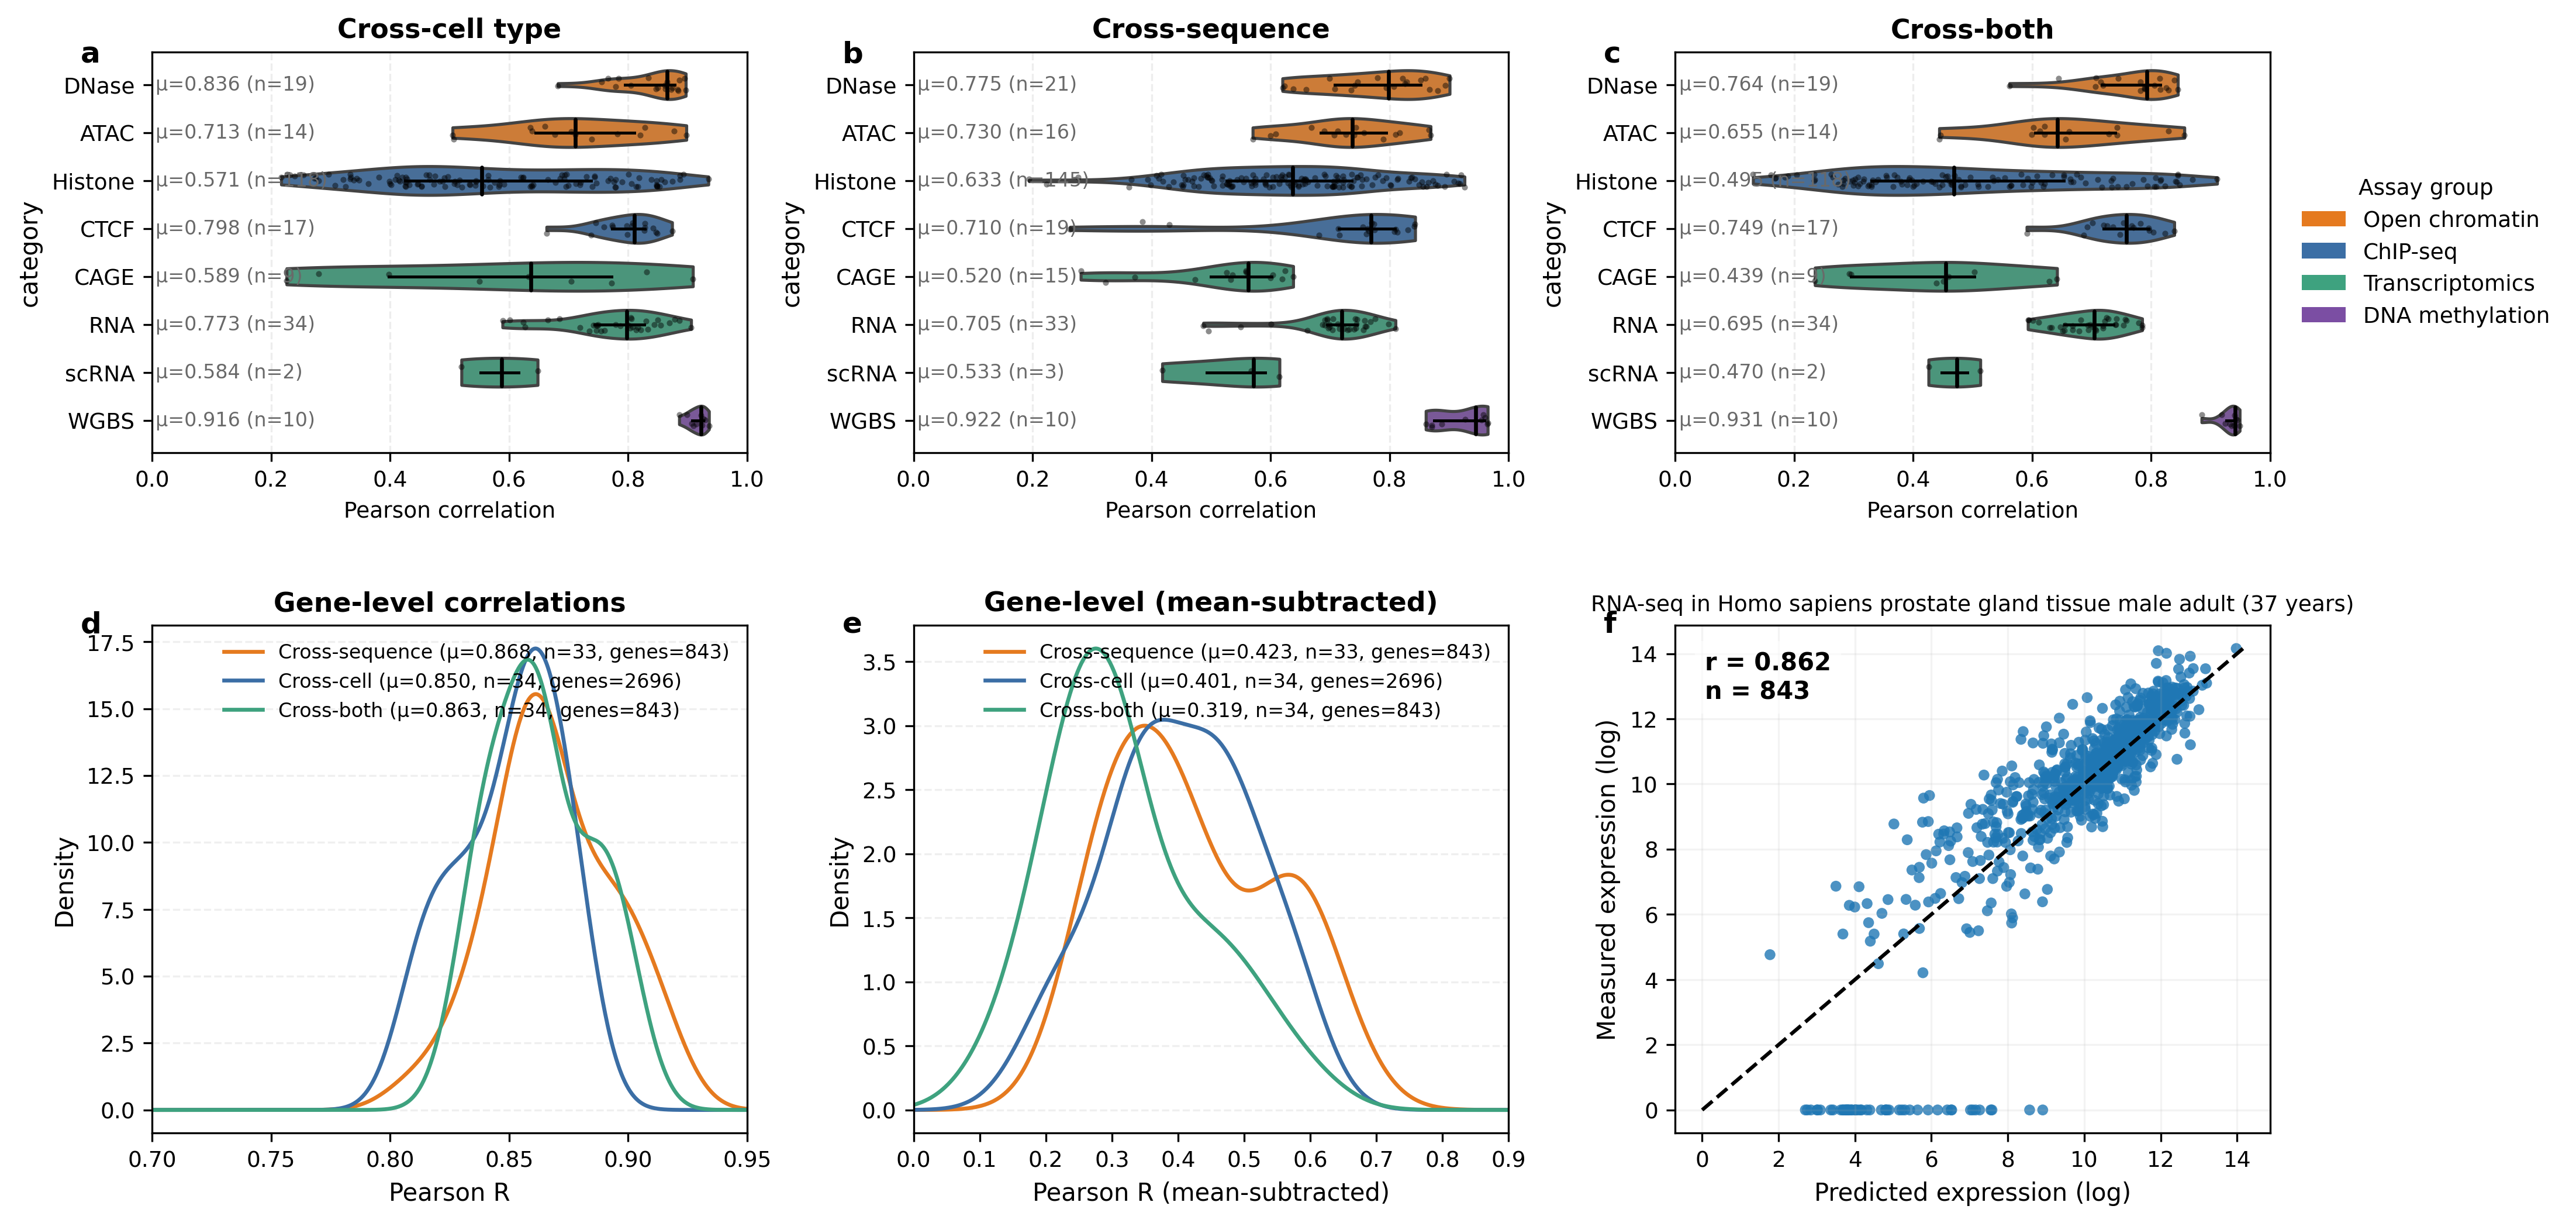

In [33]:
fig, axs = create_publication_figure(
     res_seq=res_cross_seq,
     res_cell=res_cross_cell,
     res_both=res_cross_both,
     genes_df=genes_df,
     cells_df=cells,    
     sel_tissue='267_rna_total_encode',
     exclude_pairs=exclude,
     output_pdf='/project/deeprna/figures/revision/fig2/fig2.pdf',
     output_png=None,
     xboth_pred_mat=genes_xboth,
     xboth_encode_mat=genes_xboth_encode,
     figsize=(15,8)
 )
plt.show()

## Spearman correlations

In [7]:
# gene-level correlations
genes_df = pd.read_csv('/project/deeprna/data/Homo_sapiens.gene_info.tsv', sep='\t')
coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding', 'Symbol'].values

genes_xboth = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_both_genebody/all_expressions_grt.csv', index_col=0)
genes_xcell = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_celltype_genebody/all_expressions_grt.csv', index_col=0)
genes_xregion = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_region_genebody/all_expressions_grt.csv', index_col=0)
genes_xboth_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_both_genebody/all_expressions_encode.csv', index_col=0)
genes_xcell_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_celltype_genebody/all_expressions_encode.csv', index_col=0)
genes_xregion_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_region_genebody/all_expressions_encode.csv', index_col=0)
coding_genes_xboth = genes_xboth[genes_xboth.index.isin(coding_genes)]
coding_genes_xcell = genes_xcell[genes_xcell.index.isin(coding_genes)]
coding_genes_xregion = genes_xregion[genes_xregion.index.isin(coding_genes)]
coding_genes_xboth_encode = genes_xboth_encode[genes_xboth_encode.index.isin(coding_genes)]
coding_genes_xcell_encode = genes_xcell_encode[genes_xcell_encode.index.isin(coding_genes)]
coding_genes_xregion_encode = genes_xregion_encode[genes_xregion_encode.index.isin(coding_genes)]

# Filter out zero expression genes if zero across all samples
zero_genes = {'cross-region': set(), 'cross-cell': set(), 'cross-both': set()}
for gene in coding_genes_xregion_encode.index:
    if coding_genes_xregion_encode.loc[gene].max() == 0 and coding_genes_xregion.loc[gene].max() == 0:
        zero_genes['cross-region'].add(gene)
for gene in coding_genes_xcell_encode.index:
    if coding_genes_xcell_encode.loc[gene].max() == 0 and coding_genes_xcell.loc[gene].max() == 0:
        zero_genes['cross-cell'].add(gene)
for gene in coding_genes_xboth_encode.index:
    if coding_genes_xboth_encode.loc[gene].max() == 0 and coding_genes_xboth.loc[gene].max() == 0:
        zero_genes['cross-both'].add(gene)

# Avergae correlations, excluding genes with 0 expression in all tissues
coding_genes_xcell_nonzero = coding_genes_xcell[~coding_genes_xcell.index.isin(zero_genes['cross-cell'])]
coding_genes_xcell_encode_nonzero = coding_genes_xcell_encode[~coding_genes_xcell_encode.index.isin(zero_genes['cross-cell'])]

xcell_cors = []
for i in range(coding_genes_xcell_nonzero.shape[1]):
    r, p = spearmanr(coding_genes_xcell_nonzero.iloc[:, i], coding_genes_xcell_encode_nonzero.iloc[:, i])
    xcell_cors.append(r)
print(f"Cross-cell coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(xcell_cors):.4f}, n={len(xcell_cors)}, n_genes={coding_genes_xcell_nonzero.shape[0]}")

coding_genes_xregion_nonzero = coding_genes_xregion[~coding_genes_xregion.index.isin(zero_genes['cross-region'])]
coding_genes_xregion_encode_nonzero = coding_genes_xregion_encode[~coding_genes_xregion_encode.index.isin(zero_genes['cross-region'])]

xregion_cors = []
for i in range(coding_genes_xregion_nonzero.shape[1]):
    r, p = spearmanr(coding_genes_xregion_nonzero.iloc[:, i], coding_genes_xregion_encode_nonzero.iloc[:, i])
    xregion_cors.append(r)
print(f"Cross-region coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(xregion_cors):.4f}, n={len(xregion_cors)}, n_genes={coding_genes_xregion_nonzero.shape[0]}")
coding_genes_xboth_nonzero = coding_genes_xboth[~coding_genes_xboth.index.isin(zero_genes['cross-both'])]
coding_genes_xboth_encode_nonzero = coding_genes_xboth_encode[~coding_genes_xboth_encode.index.isin(zero_genes['cross-both'])]

xboth_cors = []
for i in range(coding_genes_xboth_nonzero.shape[1]):
    r, p = spearmanr(coding_genes_xboth_nonzero.iloc[:, i], coding_genes_xboth_encode_nonzero.iloc[:, i])
    xboth_cors.append(r)
print(f"Cross-both coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(xboth_cors):.4f}, n={len(xboth_cors)}, n_genes={coding_genes_xboth_nonzero.shape[0]}")

# Mean-subtracted gene level correlations
coding_genes_xregion_nonzero_ms = coding_genes_xregion_nonzero.sub(coding_genes_xregion_nonzero.mean(axis=1), axis=0)
coding_genes_xregion_encode_nonzero_ms = coding_genes_xregion_encode_nonzero.sub(coding_genes_xregion_encode_nonzero.mean(axis=1), axis=0)
coding_genes_xboth_nonzero_ms = coding_genes_xboth_nonzero.sub(coding_genes_xboth_nonzero.mean(axis=1), axis=0)
coding_genes_xboth_encode_nonzero_ms = coding_genes_xboth_encode_nonzero.sub(coding_genes_xboth_encode_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_nonzero_ms = coding_genes_xcell_nonzero.sub(coding_genes_xcell_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_encode_nonzero_ms = coding_genes_xcell_encode_nonzero.sub(coding_genes_xcell_encode_nonzero.mean(axis=1), axis=0)

xregion_cors_ms = []
for i in range(coding_genes_xregion_nonzero_ms.shape[1]):
    r, p = spearmanr(coding_genes_xregion_nonzero_ms.iloc[:, i], coding_genes_xregion_encode_nonzero_ms.iloc[:, i])
    xregion_cors_ms.append(r)
print(f"Cross-region coding gene-level mean-subtracted Pearson R: mean={np.mean(xregion_cors_ms):.4f}, n={len(xregion_cors_ms)}, n_genes={coding_genes_xregion_nonzero_ms.shape[0]}")

xboth_cors_ms = []
for i in range(coding_genes_xboth_nonzero_ms.shape[1]):
    r, p = spearmanr(coding_genes_xboth_nonzero_ms.iloc[:, i], coding_genes_xboth_encode_nonzero_ms.iloc[:, i])
    xboth_cors_ms.append(r)
print(f"Cross-both coding gene-level mean-subtracted Pearson R: mean={np.mean(xboth_cors_ms):.4f}, n={len(xboth_cors_ms)}, n_genes={coding_genes_xboth_nonzero_ms.shape[0]}")

coding_genes_xcell_nonzero_ms = coding_genes_xcell_nonzero.sub(coding_genes_xcell_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_encode_nonzero_ms = coding_genes_xcell_encode_nonzero.sub(coding_genes_xcell_encode_nonzero.mean(axis=1), axis=0)
xcell_cors_ms = []
for i in range(coding_genes_xcell_nonzero_ms.shape[1]):
    r, p = spearmanr(coding_genes_xcell_nonzero_ms.iloc[:, i], coding_genes_xcell_encode_nonzero_ms.iloc[:, i])
    xcell_cors_ms.append(r)
print(f"Cross-cell coding gene-level mean-subtracted Pearson R: mean={np.mean(xcell_cors_ms):.4f}, n={len(xcell_cors_ms)}, n_genes={coding_genes_xcell_nonzero_ms.shape[0]}")

Cross-cell coding gene-level Pearson R (excluding 0 expression genes): mean=0.8998, n=34, n_genes=2696
Cross-region coding gene-level Pearson R (excluding 0 expression genes): mean=0.8649, n=33, n_genes=843
Cross-both coding gene-level Pearson R (excluding 0 expression genes): mean=0.8565, n=34, n_genes=843
Cross-region coding gene-level mean-subtracted Pearson R: mean=0.4774, n=33, n_genes=843
Cross-both coding gene-level mean-subtracted Pearson R: mean=0.3590, n=34, n_genes=843
Cross-cell coding gene-level mean-subtracted Pearson R: mean=0.4336, n=34, n_genes=2696


/scratch/local/ipykernel_111250/4142767027.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_111250/4142767027.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/scratch/local/ipykernel_111250/4142767027.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
/scratch/local/ipykernel_111250/4142767027.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_111250/4142767027.

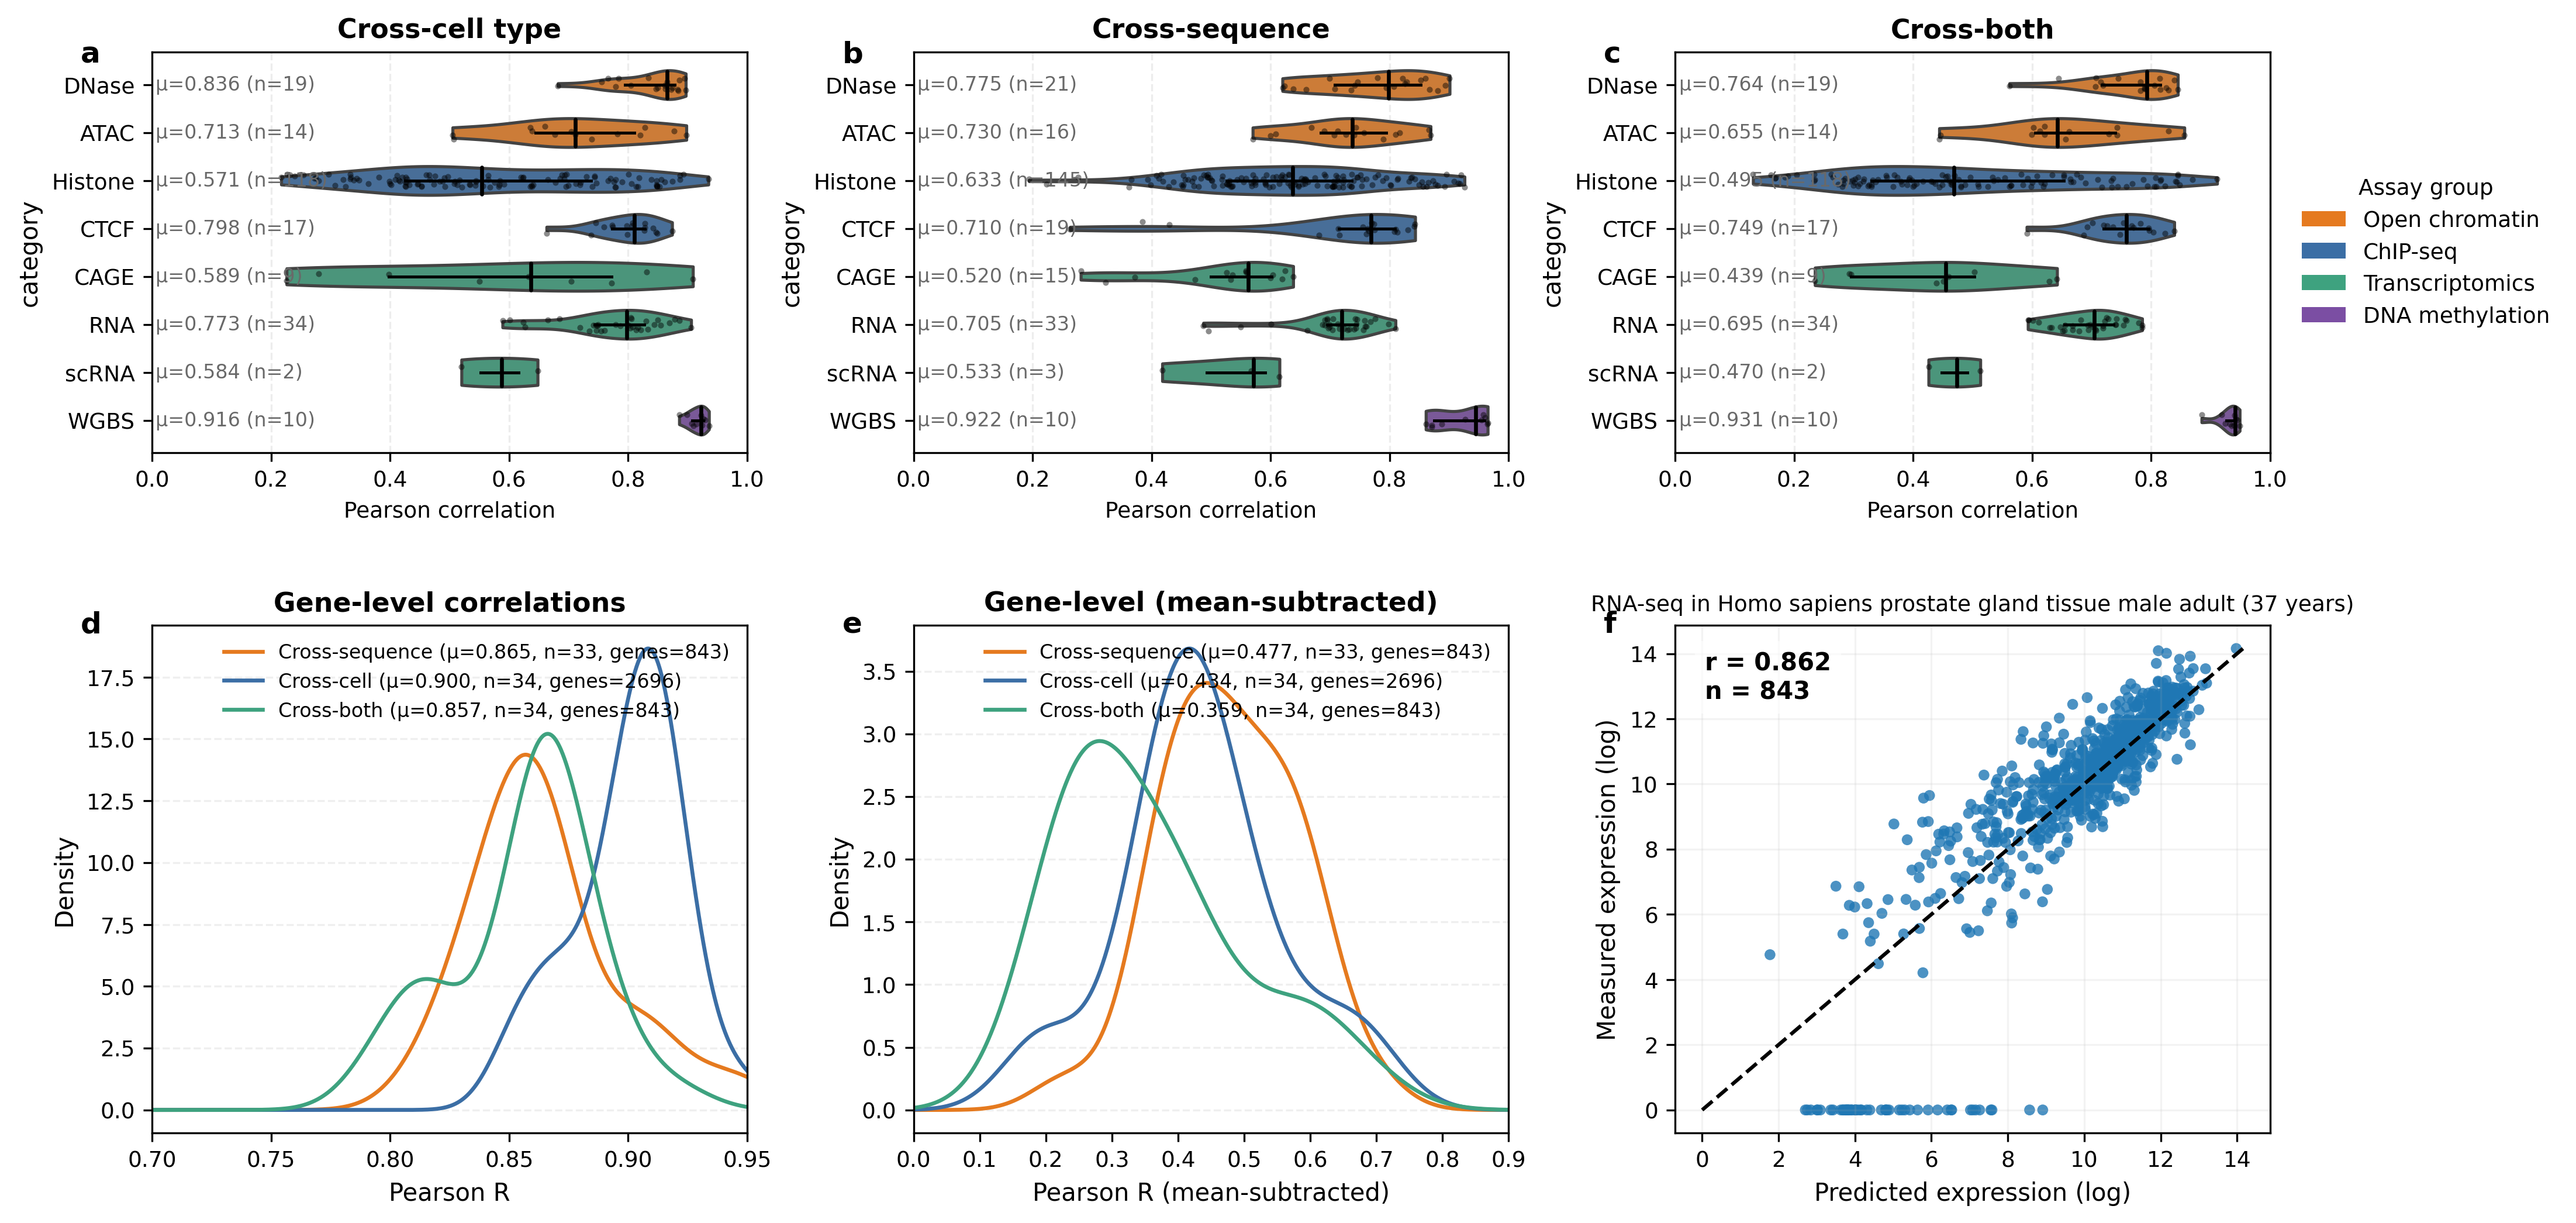

In [10]:
fig, axs = create_publication_figure(
     res_seq=res_cross_seq,
     res_cell=res_cross_cell,
     res_both=res_cross_both,
     genes_df=genes_df,
     cells_df=cells,    
     sel_tissue='267_rna_total_encode',
     exclude_pairs=exclude,
     output_pdf='/project/deeprna/figures/revision/fig2/fig2_spearman.pdf',
     output_png=None,
     xboth_pred_mat=genes_xboth,
     xboth_encode_mat=genes_xboth_encode,
     figsize=(15,8)
 )
plt.show()